In [2]:
!pip install pyspark==3.5.0 delta-spark==3.1.0

from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

builder = (
    SparkSession.builder.appName("DeltaDemo")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()


In [4]:
data = [
    (1, "John", "Electronics", 2, 300),
    (2, "Sara", "Clothing", 1, 50),
    (3, "Mike", "Electronics", 4, 600),
    (4, "Nina", "Clothing", 3, 150),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]

df = spark.createDataFrame(data, columns)


df.write.format("delta").mode("overwrite").save("/tmp/orders_delta")

In [5]:
spark.sql("CREATE TABLE orders_managed USING DELTA LOCATION '/tmp/orders_delta'")

spark.sql("CREATE TABLE orders_unmanaged USING DELTA LOCATION '/tmp/orders_delta'")

DataFrame[]

In [6]:

spark.sql("UPDATE orders_managed SET amount = amount + 20 WHERE category = 'Clothing'")

DataFrame[num_affected_rows: bigint]

In [7]:

spark.sql("DELETE FROM orders_managed WHERE quantity < 2")

DataFrame[num_affected_rows: bigint]

In [12]:
new_data = [
    (3, "Mike", "Electronics", 5, 750),
    (5, "Liam", "Furniture", 1, 200),
    (6, "Emma", "Clothing", 2, 80),
]
new_df = spark.createDataFrame(new_data, columns)



In [22]:
from delta.tables import DeltaTable
delta_table = DeltaTable.forName(spark, "orders_managed")

(delta_table.alias("t")
 .merge(new_df.alias("s"), "t.order_id = s.order_id")
 .whenMatchedUpdateAll()
 .whenNotMatchedInsertAll()
 .execute())

In [23]:
spark.sql("DESCRIBE HISTORY orders_managed").show(truncate=False)

+-------+-----------------------+------+--------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------------------------+
|ver

In [24]:
df_v0 = spark.read.format("delta").option("versionAsOf", 0).load("/tmp/orders_delta")
df_v0.show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+



In [29]:
df_latest = spark.read.format("delta").load("/tmp/orders_delta")
df_latest.show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|  Furniture|       1|   200|
|       6|         Emma|   Clothing|       2|    80|
|       1|         John|Electronics|       2|   300|
+--------+-------------+-----------+--------+------+



In [35]:
incremental_data = [
    (7, "Noah", "Electronics", 1, 150),
    (8, "Olivia", "Clothing", 4, 200),
]
incremental_df = spark.createDataFrame(incremental_data, columns)

In [36]:
incremental_df.write.format("delta").mode("append").save("/tmp/orders_delta")

In [46]:
spark.read.format("delta").load("/tmp/orders_delta").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|  Furniture|       1|   200|
|       6|         Emma|   Clothing|       2|    80|
|       1|         John|Electronics|       2|   300|
|       7|         Noah|Electronics|       1|   150|
|       8|       Olivia|   Clothing|       4|   200|
+--------+-------------+-----------+--------+------+



In [65]:
stream_df = (spark.readStream
    .format("delta")
    .load("/tmp/orders_delta"))

query = (stream_df.writeStream
    .format("console")
    .outputMode("append")
    .trigger(processingTime="5 seconds")
    .start())

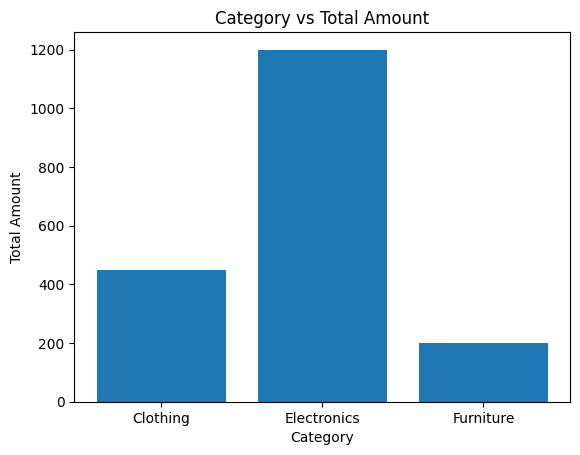

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

pdf = spark.read.format("delta").load("/tmp/orders_delta").toPandas()
category_totals = pdf.groupby("category")["amount"].sum().reset_index()

plt.bar(category_totals["category"], category_totals["amount"])
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.title("Category vs Total Amount")
plt.show()